# SHAPを使ったXAI
SHAP値を使うことで、一つ一つのデータの予測結果に対する各変数の影響度がわかるようになる。  
Permutation Importanceでは、ゼータ全体に対する変数の重要度判定であることがSHAP値とｊは異なる。  
ただ、SHAP値でもデータ全体に対する変数の重要度判定はできる。

In [1]:
from pathlib import Path
import pandas as pd
from dfply import *
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
import shap

In [2]:
%load_ext autoreload
%autoreload 2
pd.set_option("max_columns", 10000)
%matplotlib inline

必要なフォルダ作成

In [3]:
result_dir_path = Path("result")
img_dir_path = Path("img")
if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)
if not img_dir_path.exists():
    img_dir_path.mkdir(parents=True)

## データの取得
データはsckit-learnの『breast_cancer』を使う。このデータは乳がんの陽性か陰性かを分類するデータであり、  
各種特徴量は乳房腫瘤から細心生検で採取したものをデジタル画像にして、抽出した主要情報である。

In [4]:
cancer_data = load_breast_cancer()

data_y = cancer_data.target
data_x = pd.DataFrame(
    
    cancer_data.data,
    columns=cancer_data.feature_names
)
print("データ数：{}, カラム数：{}".format(data_x.shape[0], data_x.shape[1]))
data_x.head()

データ数：569, カラム数：30


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


データを訓練データとテストデータに分離する

In [5]:
train_x, test_x, train_y, test_y = train_test_split(
    data_x,
    data_y,
    test_size=0.2
)

## 分類モデルの作成
今回使用した分類モデルはXGBoostである。

In [6]:
model = XGBClassifier()
model.fit(train_x, train_y)

print("学習データの正答率：{:.0f}%, テストデータの正答率：{:.0f}".format(
    model.score(train_x, train_y) * 100,
    model.score(test_x, test_y) * 100
))

confusion_matrix(test_y, model.predict(test_x))

学習データの正答率：100%, テストデータの正答率：91


array([[43,  4],
       [ 6, 61]])

## SHAP値による予測結果への特徴量の影響の可視化

### 指定したデータに対する予測結果への特徴量の影響調査

In [7]:
target_test_index = 0
model.predict_proba(test_x)[target_test_index]

array([0.02499449, 0.9750055 ], dtype=float32)

In [8]:
target_values = test_x.iloc[target_test_index]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(target_values)

指定したデータの予測結果に対する変数の影響調査

In [9]:
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    target_values
)

In [10]:
shap_values_dt = pd.DataFrame({
    "colanme" : test_x.columns.tolist(),
    "shap_value" : shap_values[0]
})
shap_values_dt >> arrange(X.shap_value)

,colanme,shap_value
21,worst texture,-0.735276
27,worst concave points,-0.401388
19,fractal dimension error,-0.299982
26,worst concavity,-0.149537
1,mean texture,-0.144741
29,worst fractal dimension,-0.066407
15,compactness error,-0.055634
5,mean compactness,-0.011933
25,worst compactness,-0.007584
8,mean symmetry,-0.002879


### データ全体に対する要因影響調査

In [11]:
shap_values = explainer.shap_values(test_x)

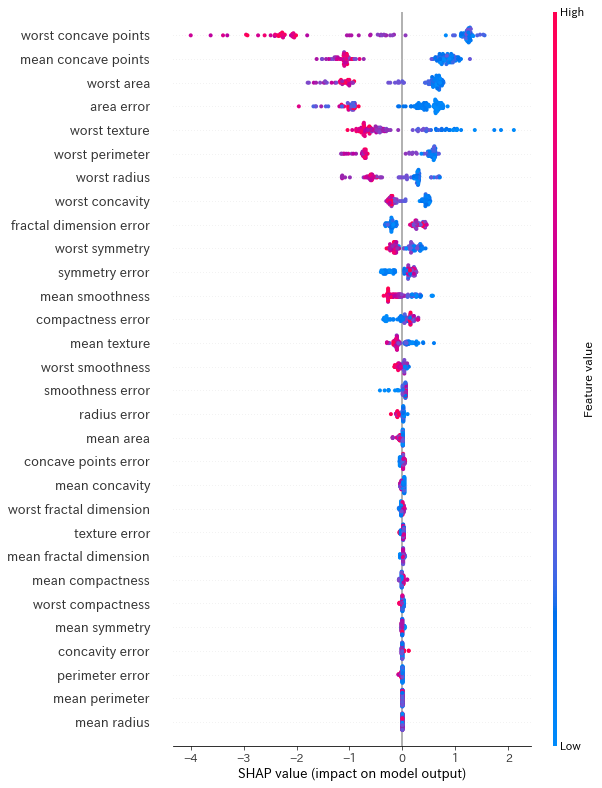

In [12]:
shap.initjs()
shap.summary_plot(
    shap_values, 
    test_x,
    max_display=len(test_x)
)

In [13]:
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values,
    test_x
)